In [ ]:
#now lets start importing required modules

In [1]:
from __future__ import print_function
import keras

from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D
from keras import backend as BK
import requests
import zipfile
from skimage import io as skyio
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3
import io
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from random import shuffle


Using TensorFlow backend.


In [2]:

# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials = {
    'IBM_API_KEY_ID': 'PvmKnYeP_zs5mJFZTmWK_U-xf60EsJpoZcooW5QoLWcJ',
    'IAM_SERVICE_ID': 'iam-ServiceId-d2ca39cb-4e15-44c8-848e-bf5bd4a711bc',
    'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.ng.bluemix.net/oidc/token',
    'BUCKET': 'eyadwatsonproj-donotdelete-pr-vtrs3j16k5uzcj',
    'FILE': 'asl_alphabet_train.zip'
}


In [3]:
def prepare_data(name_list,from_index,num_of_images,num_classes,zip_ref):            

    img_list_train = []
    img_list_train_i = []
    img_list_test = []
    img_list_test_i = []
    i = 1
    
    print('Preparing new batch')
    
    #read images from the object streaming body and directly divide train and test 80%, 20%
    for ind in range(from_index,from_index+num_of_images-2000):
        if name_list[ind][-3:] == 'jpg':
            img2 = mpimg.imread(zip_ref.open(name_list[ind]))
            img_list_train.append(name_list[ind])
            img_list_train_i.append(img2)            
    for ind in range(from_index+num_of_images-2000,min(from_index+num_of_images,len(name_list))):
        if name_list[ind][-3:] == 'jpg':
            img2 = mpimg.imread(zip_ref.open(name_list[ind]))
            img_list_test.append(name_list[ind])
            img_list_test_i.append(img2)
    img_list_train_i = np.array(img_list_train_i)
    img_list_test_i = np.array(img_list_test_i)
    img_list_train3 = [x[x.index('/') + 1:]  for x in img_list_train]
    img_list_test3 = [x[x.index('/') + 1:]  for x in img_list_test]
    img_labels_train = []
    for img_name in img_list_train3:
        if img_name.find('space') != -1:
            img_labels_train.append('SP')
        elif img_name.find('del') != -1:
            img_labels_train.append('DL')
        elif img_name.find('nothing') != -1:
            img_labels_train.append('NG')
        else:
            img_labels_train.append(img_name[0])
    img_labels_test = []
    for img_name in img_list_test3:
        if img_name.find('space') != -1:
            img_labels_test.append('SP')
        elif img_name.find('del') != -1:
            img_labels_test.append('DL')
        elif img_name.find('nothing') != -1:
            img_labels_test.append('NG')
        else:
            img_labels_test.append(img_name[0])
    #Normalize Data
    img_list_train_i = img_list_train_i/255.
    img_list_test_i = img_list_test_i/255.
    
    
    #get input shape
    #input_shape = img_list_train_i[0].shape
    #Transform labels as numbers
    encoder = LabelEncoder()
    img_label_train_encoded = encoder.fit_transform(img_labels_train)
    img_label_test_encoded = encoder.fit_transform(img_labels_test)
    #encode labels as number of classes
    img_label_train_encoded = keras.utils.to_categorical(img_label_train_encoded,num_classes)
    img_label_test_encoded = keras.utils.to_categorical(img_label_test_encoded,num_classes)
    label_set = sorted(list(set(img_labels_train)))
    #print(label_set)
    label_set_encoded = sorted(encoder.fit_transform(label_set))
    label_set_meaning = list(zip(label_set,label_set_encoded))
    print('New batch prepared!')
    img_list_train_i = np.array(img_list_train_i)
    return img_list_train_i ,img_label_train_encoded ,img_list_test_i ,img_label_test_encoded, label_set_meaning

In [4]:
def read_data(file_name):
    client_29a0929ceba942b295fb38205fe08c03 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='PvmKnYeP_zs5mJFZTmWK_U-xf60EsJpoZcooW5QoLWcJ',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

    streaming_body_1 = client_29a0929ceba942b295fb38205fe08c03.get_object(Bucket='eyadwatsonproj-donotdelete-pr-vtrs3j16k5uzcj', Key=file_name)['Body']
    zip_ref = zipfile.ZipFile(BytesIO(streaming_body_1.read()), 'r')
    #zip_ref = zipfile.ZipFile(file_name, 'r')
    name_list = zip_ref.namelist()
    shuffle(name_list)
    print('Done!')
    return name_list , zip_ref

In [5]:
def train_model(model,X,Y,batch_size,epochs):    
    model.fit(X,Y,batch_size = batch_size,epochs = epochs,verbose = 1 ) #,validation_data = (img_list_test_i,img_label_test_encoded)
    return model

In [6]:
def build_model(input_shape,num_classes):
    model = Sequential()
    model.add(Conv2D(32,kernel_size = (3,3),activation = 'relu',input_shape = input_shape))
    model.add(Conv2D(64,kernel_size = (3,3),activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(.25))
    model.add(Flatten())
    model.add(Dense(128,activation = 'relu'))
    model.add(Dropout(.5))
    model.add(Dense(num_classes,activation = 'softmax'))
    model.compile(loss = keras.losses.categorical_crossentropy,optimizer = 'adam',metrics = ['accuracy'])
    return model

In [7]:
def evaluate_model(model,X_TEST,Y_TEST):
    score = model.evaluate(X_TEST,Y_TEST,verbose = 0)
    return score[0] , score[1]

In [12]:
name_list,zip_ref =  read_data('asl_alphabet_train.zip')

Done!


In [13]:
input_shape = (200,200,3)
num_classes = 29
batch_size = 70
epochs = 10

In [14]:
num_of_images = 8000
images_total = 0
 
X_train ,Y_train ,X_test,Y_test, label_set_meaning = prepare_data(name_list,0,num_of_images,num_classes,zip_ref) 


Preparing new batch
New batch prepared!


In [15]:
model = build_model(input_shape,num_classes)

In [16]:
train_model(model,X_train,Y_train,batch_size,epochs)

Epoch 1/10
5997/5997 [==============================] - 1219s - loss: 4.3828 - acc: 0.0707  
Epoch 2/10
5997/5997 [==============================] - 1221s - loss: 2.6119 - acc: 0.2425  
Epoch 3/10
5997/5997 [==============================] - 1210s - loss: 1.7335 - acc: 0.4631  
Epoch 4/10
5997/5997 [==============================] - 1215s - loss: 1.1984 - acc: 0.6163  
Epoch 5/10
5997/5997 [==============================] - 1215s - loss: 0.8855 - acc: 0.7042  
Epoch 6/10
5997/5997 [==============================] - 1216s - loss: 0.6660 - acc: 0.7786  
Epoch 7/10
5997/5997 [==============================] - 1218s - loss: 0.5525 - acc: 0.8144  
Epoch 8/10
5997/5997 [==============================] - 1215s - loss: 0.4425 - acc: 0.8483  
Epoch 9/10
5997/5997 [==============================] - 1215s - loss: 0.3654 - acc: 0.8798  
Epoch 10/10
5997/5997 [==============================] - 1218s - loss: 0.3470 - acc: 0.8804  


In [17]:
#@title Default title text
test_loss , test_accuracy = evaluate_model(model,X_test,Y_test)
print('Test Loss = ' , test_loss)
print('Test Accuracy = ' , test_accuracy)

Test Loss =  0.882275838593
Test Accuracy =  0.733366683461


In [20]:
client_29a0929ceba942b295fb38205fe08c03 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='PvmKnYeP_zs5mJFZTmWK_U-xf60EsJpoZcooW5QoLWcJ',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')
    

DATA OCIENCB

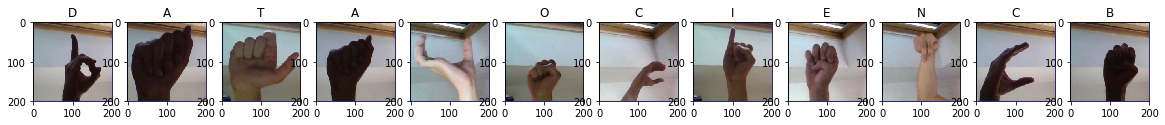

In [54]:
i = 1
ax = plt.figure(figsize = (20,10))
while i <13:
    streaming_body = client_29a0929ceba942b295fb38205fe08c03.get_object(Bucket='eyadwatsonproj-donotdelete-pr-vtrs3j16k5uzcj', Key='A%s.zip'%i)['Body']
    zip_ref = zipfile.ZipFile(BytesIO(streaming_body.read()), 'r')
    #zip_ref = zipfile.ZipFile('A%s.zip'%i, 'r')
    image = []
    #read images from the object streaming body and directly divide train and test 80%, 20%
    for img in zip_ref.namelist():
        if img[-3:] == 'jpg':
            img2 = mpimg.imread(zip_ref.open(img)) 
            img2 = img2 / 255.
            image.append(img2)

    image = np.array(image)    
    a = model.predict(image)  
    plt.subplot(1,12,i)
    
    
    l = label_set_meaning[np.argmax(a)][0]
    if l == 'SP':
        l = ' '
    plt.title(l)    
    plt.imshow(image[0])
    plt.xticks = []
    plt.yticks = []
    plt.xlabels = []
    plt.ylabels = []
    print(l, end="")
    i += 1

J

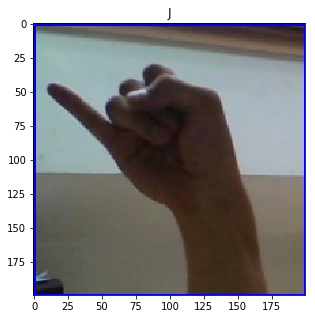

In [58]:
#get sample images and predict labels
client_29a0929ceba942b295fb38205fe08c03 = ibm_boto3.client(service_name='s3',
        ibm_api_key_id='PvmKnYeP_zs5mJFZTmWK_U-xf60EsJpoZcooW5QoLWcJ',
        ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
        config=Config(signature_version='oauth'),
        endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')
i = 1
ax = plt.figure(figsize = (5,5))
while i <2:
    streaming_body_8 = client_29a0929ceba942b295fb38205fe08c03.get_object(Bucket='eyadwatsonproj-donotdelete-pr-vtrs3j16k5uzcj', Key='sample.zip')['Body']
    zip_ref = zipfile.ZipFile(BytesIO(streaming_body_8.read()), 'r')
    image = []
    #read images from the object streaming body and directly divide train and test 80%, 20%
    for img in zip_ref.namelist():
        if img[-3:] == 'jpg':
            img2 = mpimg.imread(zip_ref.open(img)) 
            img2 = img2 / 255.
            image.append(img2)

    image = np.array(image)    
    a = model.predict(image)  
    plt.subplot(1,1,i)
    
    
    l = label_set_meaning[np.argmax(a)][0]
    if l == 'SP':
        l = ' '
    plt.title(l)
    plt.xticks = []
    plt.yticks = []
    plt.imshow(image[0])
    print(l, end="")
    i += 1

In [42]:
from keras.models import load_model
client_29a0929ceba942b295fb38205fe08c03 = ibm_boto3.client(service_name='s3',
ibm_api_key_id='PvmKnYeP_zs5mJFZTmWK_U-xf60EsJpoZcooW5QoLWcJ',
ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
config=Config(signature_version='oauth'),
endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')
streaming_body_1 = client_29a0929ceba942b295fb38205fe08c03.get_object(Bucket='eyadwatsonproj-donotdelete-pr-vtrs3j16k5uzcj', Key='ASL_model.zip')['Body']
zip_ref = zipfile.ZipFile(BytesIO(streaming_body_1.read()), 'r')
#new_model = load_model(zip_ref.open(zip_ref.namelist()[0]))
zip_ref.open(zip_ref.namelist()[0])

<zipfile.ZipExtFile name='ASL_model.h5' mode='r' compress_type=deflate>